# JSON in SQLite und Geschäftslogik

**Kerngeschäftslogik**

**Auftrag** (Produktionsauftrag)

- Der Auftrag ist die zentrale Einheit im Produktionsprozess.

- Jeder Auftrag enthält ein Produktionsdatum (z. B. Abgangsdatum oder Ausgangsdatum).

- Ein Auftrag gilt als abgeschlossen, wenn die Anzahl der fertigen Paletten (IST) ungefähr der Anzahl der geplanten Paletten (SOLL) entspricht.

- Wenn die Mengen abweichen, spricht man von einer Mindermenge (Unterproduktion) oder Überproduktion.

**Rohware**

Rohware wird separat über Schritte wie „neue Rohware“ erfasst.

Aktuell wird sie häufig verspätet eingetragen, z. B. am Schichtende oder gebündelt – nicht immer zum realen Zeitpunkt des Verbrauchs.

In Zukunft sollen automatisierte Waagen verwendet werden – dadurch wird utcDone (Zeitstempel) eine größere Bedeutung haben.

**Nachricht**
Nachrichten werden aktuell nicht für die Analyse berücksichtigt.



**Ziel**

Ziel ist es, Abfrage- und Analyseskripte zu entwickeln, die der Logik des Produktionsprozesses entsprechen.
Unten folgt ein konzeptioneller Plan mit fertigen SQL-Codebausteinen, die an reale Daten angepasst werden können.

Strukturmodell: Tabellenbeziehungen

| Tabelle            | Zweck                                                 | Beziehungen                    |
| ------------------ | ----------------------------------------------------- | ------------------------------ |
| `auftraege_full`   | Produktionsaufträge                                   | `id` → `steps_full.auftrag_id` |
| `steps_full`       | Schritte im Workflow                                  | `id` → `inputs_full.step_id`   |
| `steps_<name>`     | Aufgesplittete Schritte nach Typ (z. B. neue Rohware) | Teilmenge aus `steps_full`     |
| `inputs_full`      | Alle erfassten Eingabewerte (zentral)                 | `step_id` → `steps_full.id`    |
| `inputs_<name>`    | Aufgesplittete Tabellen nach Eingaben                 | Teilmengen aus `inputs_full`   |
| `dropdown_options` | Optionen von Dropdown-Feldern                         | `input_id` → `inputs_full.id`  |


Hinweise:

- steps_<name> enthält z. B. steps_neue_rohware, steps_qualität, steps_autrag_abarbeiten usw.
- inputs_<name> enthält z. B. inputs_gewicht, inputs_anzahl_paletten, inputs_artikelnummer usw.
- Beide aufgesplitteten Gruppen (inputs_* und steps_*) dienen der vereinfachten Filterung und gezielten Analyse.
- Die Normalisierung erleichtert spätere SQL-Auswertungen und verhindert Mehrdeutigkeiten.

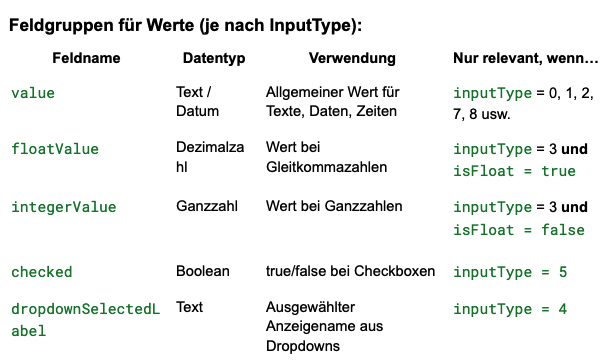

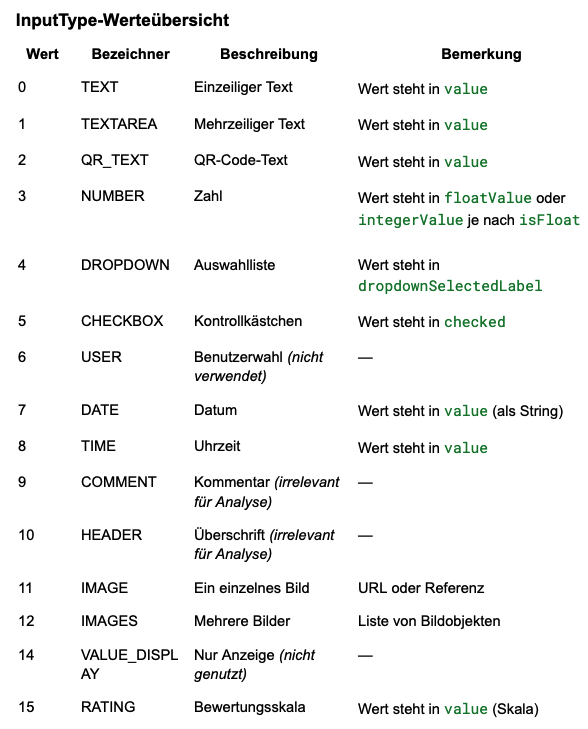

Ein Schritt ist dann abgeschlossen (= mit Werten gefüllt), wenn das Feld UtcDone einen Wert über 0 hat. Dann steht da der UNIX TIMESTAMP vom Zeitpunkt, an dem der ausgefüllte Schritt gespeichert wurde. Davor kann man die Werte in dem Schritt nicht verarbeiten.





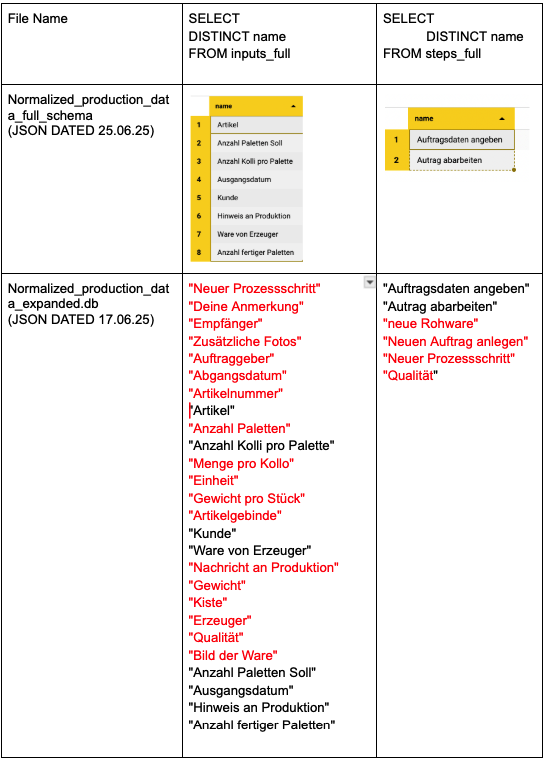

#NEW DATA (25_JUN_2025)

In [ ]:
import json
import pandas as pd
import sqlite3
import ast
from google.colab import files

# Define the full list of expected input and step table names based on the schema
# You might need to adjust this list based on your complete conceptual model
expected_input_tables = [
    "inputs_abgangsdatum",
    "inputs_anzahl_kolli_pro_palette",
    "inputs_anzahl_paletten", # Based on previous output, this might be a generic name
    "inputs_anzahl_paletten_soll",
    "inputs_anzahl_fertiger_paletten",
    "inputs_artikel",
    "inputs_artikelgebinde", # Based on previous output, this might be missing in data
    "inputs_artikelnummer",
    "inputs_auftraggeber", # Based on previous output, this might be missing in data
    "inputs_ausgangsdatum",
    "inputs_bild_der_ware", # Based on previous output, this might be missing in data
    "inputs_deine_anmerkung", # Based on previous output, this might be missing in data
    "inputs_einheit", # Based on previous output, this might be missing in data
    "inputs_empfänger", # Based on previous output, this might be missing in data
    "inputs_erzeuger", # Based on previous output, this might be missing in data
    "inputs_gewicht", # Based on previous output, this might be missing in data
    "inputs_gewicht_pro_stück", # Based on previous output, this might be missing in data
    "inputs_hinweis_an_produktion",
    "inputs_kiste", # Based on previous output, this might be missing in data
    "inputs_kunde",
    "inputs_menge_pro_kollo", # Based on previous output, this might be missing in data
    "inputs_nachricht_an_produktion", # Based on previous output, this might be missing in data
    "inputs_neuer_prozessschritt", # Based on previous output, this might be missing in data
    "inputs_qualität", # Based on previous output, this might be missing in data
    "inputs_ware_von_erzeuger",
    "inputs_zusätzliche_fotos", # Based on previous output, this might be missing in data
]

expected_step_tables = [
    "steps_auftragsdaten_angeben",
    "steps_autrag_abarbeiten",
    "steps_neuen_auftrag_anlegen", # Based on previous output, this might be missing in data
    "steps_neuer_prozessschritt", # Based on previous output, this might be missing in data
    "steps_qualität", # Based on previous output, this might be missing in data
    "steps_neue_rohware", # Based on previous output, this might be missing in data
]


# === HOCHLADEN DER JSON-DATEI ===
uploaded = files.upload()
json_file_path = list(uploaded.keys())[0]

with open(json_file_path, "r", encoding="utf-8") as f:
    json_data = json.load(f)

# === 1. Initialisierung von DataFrames ===
auftraege_rows = []
workflow_rows = []
input_rows = []

for auftrag in json_data:
    auftraege_rows.append({
        "id": auftrag.get("id"),
        "refId": auftrag.get("refId"),
        "name": auftrag.get("name"),
        "description": auftrag.get("description"),
        "tagFilter": auftrag.get("tagFilter"),
    })

    for step in auftrag.get("workflowSteps", []):
        workflow_rows.append({
            "id": step.get("id"),
            "auftrag_id": auftrag.get("id"),
            "refId": step.get("refId"),
            "name": step.get("name"),
            "description": step.get("description"),
            "utcDone": step.get("utcDone")
        })

        for row in step.get("inputRows", []):
            input_rows.append({
                "id": row.get("id"),
                "step_id": step.get("id"),
                "refId": row.get("refId"),
                "name": row.get("name"),
                "inputType": row.get("inputType"),
                "value": row.get("value"),
                "integerValue": row.get("integerValue"),
                "floatValue": row.get("floatValue"),
                "isFloat": row.get("isFloat"),
                "checked": row.get("checked"),
                "dropdownSelectedLabel": row.get("dropdownSelectedLabel"),
                "dropdownOptions": row.get("dropdownOptions")
            })

# === 2. Erstellung der DataFrames ===
df_auftraege = pd.DataFrame(auftraege_rows)
df_workflow = pd.DataFrame(workflow_rows)
df_inputs_full = pd.DataFrame(input_rows)

# === 3. Dropdown-Optionen extrahieren ===
df_inputs_full["dropdownOptions"] = df_inputs_full["dropdownOptions"].astype(str)
dropdown_options_list = []

for idx, row in df_inputs_full.iterrows():
    try:
        options = row.get("dropdownOptions")
        if isinstance(options, str) and options.strip():
            parsed = ast.literal_eval(options)
            if isinstance(parsed, list):
                for opt in parsed:
                    if isinstance(opt, dict):
                        dropdown_options_list.append({
                            "input_id": row["id"],
                            "option_value": opt.get("value"),
                            "option_label": opt.get("label")
                        })
    except:
        pass

df_dropdown_options = pd.DataFrame(dropdown_options_list)


# === 4. Schreiben in SQLite-Datenbank (Create all expected tables first) ===
db_path = "normalized_production_data_full_schema.db" # New database file to avoid conflicts
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Function to get a basic schema for split tables
def get_split_table_schema(table_name, is_input_table=True):
    base_schema = f'CREATE TABLE IF NOT EXISTS "{table_name}" (\n'
    if is_input_table:
        base_schema += '"id" TEXT,\n"step_id" TEXT,\n"refId" TEXT,\n"name" TEXT,\n"inputType" INTEGER,\n"value" TEXT,\n"integerValue" INTEGER,\n"floatValue" INTEGER,\n"isFloat" INTEGER,\n"checked" INTEGER,\n"dropdownSelectedLabel" TEXT,\n"dropdownOptions" TEXT\n);'
    else: # Step table
         base_schema += '"id" TEXT,\n"auftrag_id" TEXT,\n"refId" TEXT,\n"name" TEXT,\n"description" TEXT,\n"utcDone" INTEGER\n);'
    return base_schema

# Create core tables
df_auftraege.to_sql("auftraege_full", conn, index=False, if_exists="replace")
df_workflow.to_sql("steps_full", conn, index=False, if_exists="replace")
df_inputs_full.to_sql("inputs_full", conn, index=False, if_exists="replace")

# Create dropdown_options table if not empty
if not df_dropdown_options.empty:
    schema_dropdown_options = pd.io.sql.get_schema(df_dropdown_options, "dropdown_options", con=conn)
    schema_dropdown_options = schema_dropdown_options.replace(",\n)", "\n)") # Remove trailing comma before the closing parenthesis
    cursor.execute(f"DROP TABLE IF EXISTS dropdown_options;") # Drop existing table if it exists
    cursor.execute(schema_dropdown_options) # Create table with corrected schema
    df_dropdown_options.to_sql("dropdown_options", conn, index=False, if_exists="append") # Append data
else:
    print("df_dropdown_options is empty, skipping table creation and insertion for dropdown_options.")


# Create all expected input split tables
print("\nCreating all expected input split tables...")
for table_name in expected_input_tables:
    schema = get_split_table_schema(table_name, is_input_table=True)
    try:
        cursor.execute(schema)
        print(f"Created table: {table_name}")
    except sqlite3.Error as e:
        print(f"Error creating table {table_name}: {e}")

# Create all expected step split tables
print("\nCreating all expected step split tables...")
for table_name in expected_step_tables:
    schema = get_split_table_schema(table_name, is_input_table=False)
    try:
        cursor.execute(schema)
        print(f"Created table: {table_name}")
    except sqlite3.Error as e:
        print(f"Error creating table {table_name}: {e}")

conn.commit() # Commit schema changes


# === 5. Populate split tables with data ===
print("\nPopulating split tables with data...")

# Populate input split tables
if not df_inputs_full.empty:
    for name, df_group in df_inputs_full.groupby("name"):
        # Convert name to table format
        table_name = f"inputs_{name.lower().replace(' ', '_').replace('ä', 'ae').replace('ö', 'oe').replace('ü', 'ue').replace('ß', 'ss')}"
        if table_name in expected_input_tables: # Only insert if the table was in our expected list
             try:
                df_group.to_sql(table_name, conn, index=False, if_exists="append")
                print(f"Populated {table_name} with {len(df_group)} rows.")
             except sqlite3.Error as e:
                print(f"Error populating table {table_name}: {e}")
        else:
            # This case handles names in data not in the expected_input_tables list
            # For now, we just print a message. A more robust solution would create the table here.
            print(f"Warning: Input name '{name}' found in data, but table '{table_name}' is not in the expected list. Data not inserted into a split table.")


# Populate step split tables
if not df_workflow.empty:
    for name, df_group in df_workflow.groupby("name"):
        # Convert name to table format
        table_name = f"steps_{name.lower().replace(' ', '_').replace('ä', 'ae').replace('ö', 'oe').replace('ü', 'ue').replace('ß', 'ss')}"
        if table_name in expected_step_tables: # Only insert if the table was in our expected list
            try:
                df_group.to_sql(table_name, conn, index=False, if_exists="append")
                print(f"Populated {table_name} with {len(df_group)} rows.")
            except sqlite3.Error as e:
                print(f"Error populating table {table_name}: {e}")
        else:
             # This case handles names in data not in the expected_step_tables list
             print(f"Warning: Step name '{name}' found in data, but table '{table_name}' is not in the expected list. Data not inserted into a split table.")


conn.commit() # Commit data insertion changes
cursor.close()
conn.close()

# === 6. Download the SQLite file ===
files.download(db_path)

Saving KG_Export_Aufträge.json to KG_Export_Aufträge.json
df_dropdown_options is empty, skipping table creation and insertion for dropdown_options.

Creating all expected input split tables...
Created table: inputs_abgangsdatum
Created table: inputs_anzahl_kolli_pro_palette
Created table: inputs_anzahl_paletten
Created table: inputs_anzahl_paletten_soll
Created table: inputs_anzahl_fertiger_paletten
Created table: inputs_artikel
Created table: inputs_artikelgebinde
Created table: inputs_artikelnummer
Created table: inputs_auftraggeber
Created table: inputs_ausgangsdatum
Created table: inputs_bild_der_ware
Created table: inputs_deine_anmerkung
Created table: inputs_einheit
Created table: inputs_empfänger
Created table: inputs_erzeuger
Created table: inputs_gewicht
Created table: inputs_gewicht_pro_stück
Created table: inputs_hinweis_an_produktion
Created table: inputs_kiste
Created table: inputs_kunde
Created table: inputs_menge_pro_kollo
Created table: inputs_nachricht_an_produktion


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import sqlite3

db_path = "normalized_production_data_full_schema.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables created in the SQLite database:")
for table in tables:
    print(table[0])

cursor.close()
conn.close()

Tables created in the SQLite database:
auftraege_full
steps_full
inputs_full
inputs_abgangsdatum
inputs_anzahl_kolli_pro_palette
inputs_anzahl_paletten
inputs_anzahl_paletten_soll
inputs_anzahl_fertiger_paletten
inputs_artikel
inputs_artikelgebinde
inputs_artikelnummer
inputs_auftraggeber
inputs_ausgangsdatum
inputs_bild_der_ware
inputs_deine_anmerkung
inputs_einheit
inputs_empfänger
inputs_erzeuger
inputs_gewicht
inputs_gewicht_pro_stück
inputs_hinweis_an_produktion
inputs_kiste
inputs_kunde
inputs_menge_pro_kollo
inputs_nachricht_an_produktion
inputs_neuer_prozessschritt
inputs_qualität
inputs_ware_von_erzeuger
inputs_zusätzliche_fotos
steps_auftragsdaten_angeben
steps_autrag_abarbeiten
steps_neuen_auftrag_anlegen
steps_neuer_prozessschritt
steps_qualität
steps_neue_rohware
